# Unpaired PBMC, ATAC to expression

Use BABEL to impute single-cell expression signatures from scATAC-seq data, and evaluate those expression imputations.

For this, we use the scATAC-seq PBMC data available from 10x: https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_v1_pbmc_10k.
We specifically use the filtered peak by cell matrix `atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5`, which has the md5 checksum: `ca630296bd0e621e89c67c9540f0e3ad`. This specific file can also be downloaded at the following link: https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_10k/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5

After downloading the file containing scATAC-seq, we can generate expression predictions using the following command. This command assumes that you have downloaded the pretrained BABEL model (see main page README.md) into `MODEL_DIR`.

```bash
python ~/projects/babel/bin/predict_model.py --checkpoint MODEL_DIR --data atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5 --outdir babel_atac_to_rna_pbmc --noplot --liftHg19toHg38 --transonly --device 0
```
Some of the options used the command above:
* `--noplot` skips plotting logic
* `--liftHg19toHg38` enables using liftOver (which you must have installed on your system and in your PATH) to convert the input Hg19 coordinates to Hg38, which BABEL is trained on
* `--transonly` tells BABEL to only do cross-domain translation
* `--device 0` tells BABEL to run on the 0-th (first with zero indexing) GPU

In [1]:
import os
import sys
import importlib

import numpy as np
import pandas as pd
import sklearn
from sklearn import feature_extraction
import anndata as ad
import scanpy as sc
import mvlearn
import matplotlib.pyplot as plt

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'babel')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
assert os.path.isdir(DATA_DIR)
import sc_data_loaders
import babel.adata_utils as adata_utils
import interpretation
import metrics
import babel.plot_utils as plot_utils
import babel.utils as utils

## Load in predictions and annotations

This metadata file corresponds to the PBMC data and analysis described at:
https://satijalab.org/signac/articles/pbmc_vignette.html

In [2]:
pbmc_seurat_atac_obs = pd.read_csv(os.path.join(DATA_DIR, "10x", "pbmc_atac_obs_metadata.csv"), index_col=0)
pbmc_seurat_atac_obs

ClusterID    ClusterName  \
AAACGAAAGAGCGAAA-1          1      CD14 Mono   
AAACGAAAGAGTTTGA-1          1      CD14 Mono   
AAACGAAAGCGAGCTA-1          7     NK CD56Dim   
AAACGAAAGTGCTGAG-1          1      CD14 Mono   
AAACGAAGTCAGGCTC-1          2     CD4 Memory   
...                       ...            ...   
TTTGTGTTCATGCTTT-1          1      CD14 Mono   
TTTGTGTTCCGAGAGA-1          1      CD14 Mono   
TTTGTGTTCGAAGCCC-1         12  NK CD56bright   
TTTGTGTTCTACTTTG-1          6      CD8 Naive   
TTTGTGTTCTTGTGCC-1          4      CD4 Naive   

                    DNase_sensitive_region_fragments  TSS_enrichment  \
AAACGAAAGAGCGAAA-1                              8529        4.623532   
AAACGAAAGAGTTTGA-1                              9539        4.438665   
AAACGAAAGCGAGCTA-1                             17405        5.384285   
AAACGAAAGTGCTGAG-1                              6970        5.315153   
AAACGAAGTCAGGCTC-1                              3969        4.817100   
...                                              ...             ...   
TTTGTGTTCATGCTTT-1                              7349        5.397088   
TTTGTGTTCCGAGAGA-1                              7528        5.134192   
TTTGTGTTCGAAGCCC-1                             11512        5.332720   
TTTGTGTTCTACTTTG-1                             16461        5.624919   
TTTGTGTTCTTGTGCC-1                              9988        5.012185   

                    TSS_fragments  TSS_percentile  blacklist_ratio  \
AAACGAAAGAGCGAAA-1           4152            0.20         0.000301   
AAACGAAAGAGTTTGA-1           4855            0.13         0.000616   
AAACGAAAGCGAGCTA-1          10689            0.62         0.000926   
AAACGAAAGTGCTGAG-1           3781            0.58         0.000000   
AAACGAAGTCAGGCTC-1           2637            0.29         0.000946   
...                           ...             ...              ...   
TTTGTGTTCATGCTTT-1           3778            0.63         0.000347   
TTTGTGTTCCGAGAGA-1           3841            0.48         0.000781   
TTTGTGTTCGAAGCCC-1           7379            0.59         0.001749   
TTTGTGTTCTACTTTG-1          10849            0.74         0.001765   
TTTGTGTTCTTGTGCC-1           6313            0.41         0.001472   

                    blacklist_region_fragments     cell_id  chimeric  ...  \
AAACGAAAGAGCGAAA-1                           2     _cell_0       235  ...   
AAACGAAAGAGTTTGA-1                           5     _cell_1       191  ...   
AAACGAAAGCGAGCTA-1                          13     _cell_2       607  ...   
AAACGAAAGTGCTGAG-1                           0     _cell_4       144  ...   
AAACGAAGTCAGGCTC-1                           3     _cell_5        84  ...   
...                                        ...         ...       ...  ...   
TTTGTGTTCATGCTTT-1                           2  _cell_8628       149  ...   
TTTGTGTTCCGAGAGA-1                           5  _cell_8629       177  ...   
TTTGTGTTCGAAGCCC-1                          17  _cell_8630       401  ...   
TTTGTGTTCTACTTTG-1                          24  _cell_8631       688  ...   
TTTGTGTTCTTGTGCC-1                          12  _cell_8632       240  ...   

                       orig_ident  passed_filters pct_reads_in_peaks  \
AAACGAAAGAGCGAAA-1  SeuratProject           10444          63.605900   
AAACGAAAGAGTTTGA-1  SeuratProject           11111          73.026730   
AAACGAAAGCGAGCTA-1  SeuratProject           21556          65.132675   
AAACGAAAGTGCTGAG-1  SeuratProject            8253          69.804920   
AAACGAAGTCAGGCTC-1  SeuratProject            5144          61.625195   
...                           ...             ...                ...   
TTTGTGTTCATGCTTT-1  SeuratProject            8976          64.226830   
TTTGTGTTCCGAGAGA-1  SeuratProject            8879          72.057660   
TTTGTGTTCGAAGCCC-1  SeuratProject           13665          71.115990   
TTTGTGTTCTACTTTG-1  SeuratProject           20179          67.372020   
TTTGTGTTCTTGTGCC-1  

This loads in the ATAC > RNA predictions generated by BABEL

In [3]:
pbmc_rna = ad.read_h5ad("babel_atac_to_rna_pbmc/atac_rna_adata.h5ad")
if not isinstance(pbmc_rna.X, np.ndarray):
    pbmc_rna.X = pbmc_rna.X.toarray()
pbmc_rna

AnnData object with n_obs × n_vars = 8633 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [4]:
# Subset to the cells that we have Signac annotations for
intersected_barcodes = [bc for bc in pbmc_rna.obs_names if bc in pbmc_seurat_atac_obs.index]
pbmc_rna = pbmc_rna[intersected_barcodes]
pbmc_rna

View of AnnData object with n_obs × n_vars = 6980 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [5]:
pbmc_rna.obs['seurat_clustername'] = pbmc_seurat_atac_obs['ClusterName']
pbmc_rna.obs.head()

Trying to set attribute `.obs` of view, making a copy.


source_file  n_counts  \
index                                                                       
AAACGAAAGAGCGAAA-1  atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5    2194.0   
AAACGAAAGAGTTTGA-1  atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5    2771.0   
AAACGAAAGCGAGCTA-1  atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5    2599.0   
AAACGAAAGTGCTGAG-1  atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5    1856.0   
AAACGAAGTCAGGCTC-1  atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5     413.0   

                    log1p_counts  n_genes  size_factors seurat_clustername  
index                                                                       
AAACGAAAGAGCGAAA-1      7.693937     2194           1.0          CD14 Mono  
AAACGAAAGAGTTTGA-1      7.927324     2771           1.0          CD14 Mono  
AAACGAAAGCGAGCTA-1      7.863267     2599           1.0         NK CD56Dim  
AAACGAAAGTGCTGAG-1      7.526718     1856           1.0          CD14 Mono  
AAACGAAGTCAGGCTC-1      6.025866      413           1.0         CD4 Memory

In [6]:
# Compute size-normalized, log-normalized counts
pbmc_rna_log = adata_utils.normalize_count_table(pbmc_rna, size_factors=True, log_trans=True, normalize=False)
pbmc_rna_log

INFO:root:Computing size factors
INFO:root:Log transforming data


AnnData object with n_obs × n_vars = 6980 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors', 'seurat_clustername'
    uns: 'median_counts'

In [7]:
# Perform dimensionality reduction and clustering
plot_utils.preprocess_anndata(pbmc_rna_log, louvain_resolution=0, leiden_resolution=0.8)

INFO:root:Skipping louvain clustering


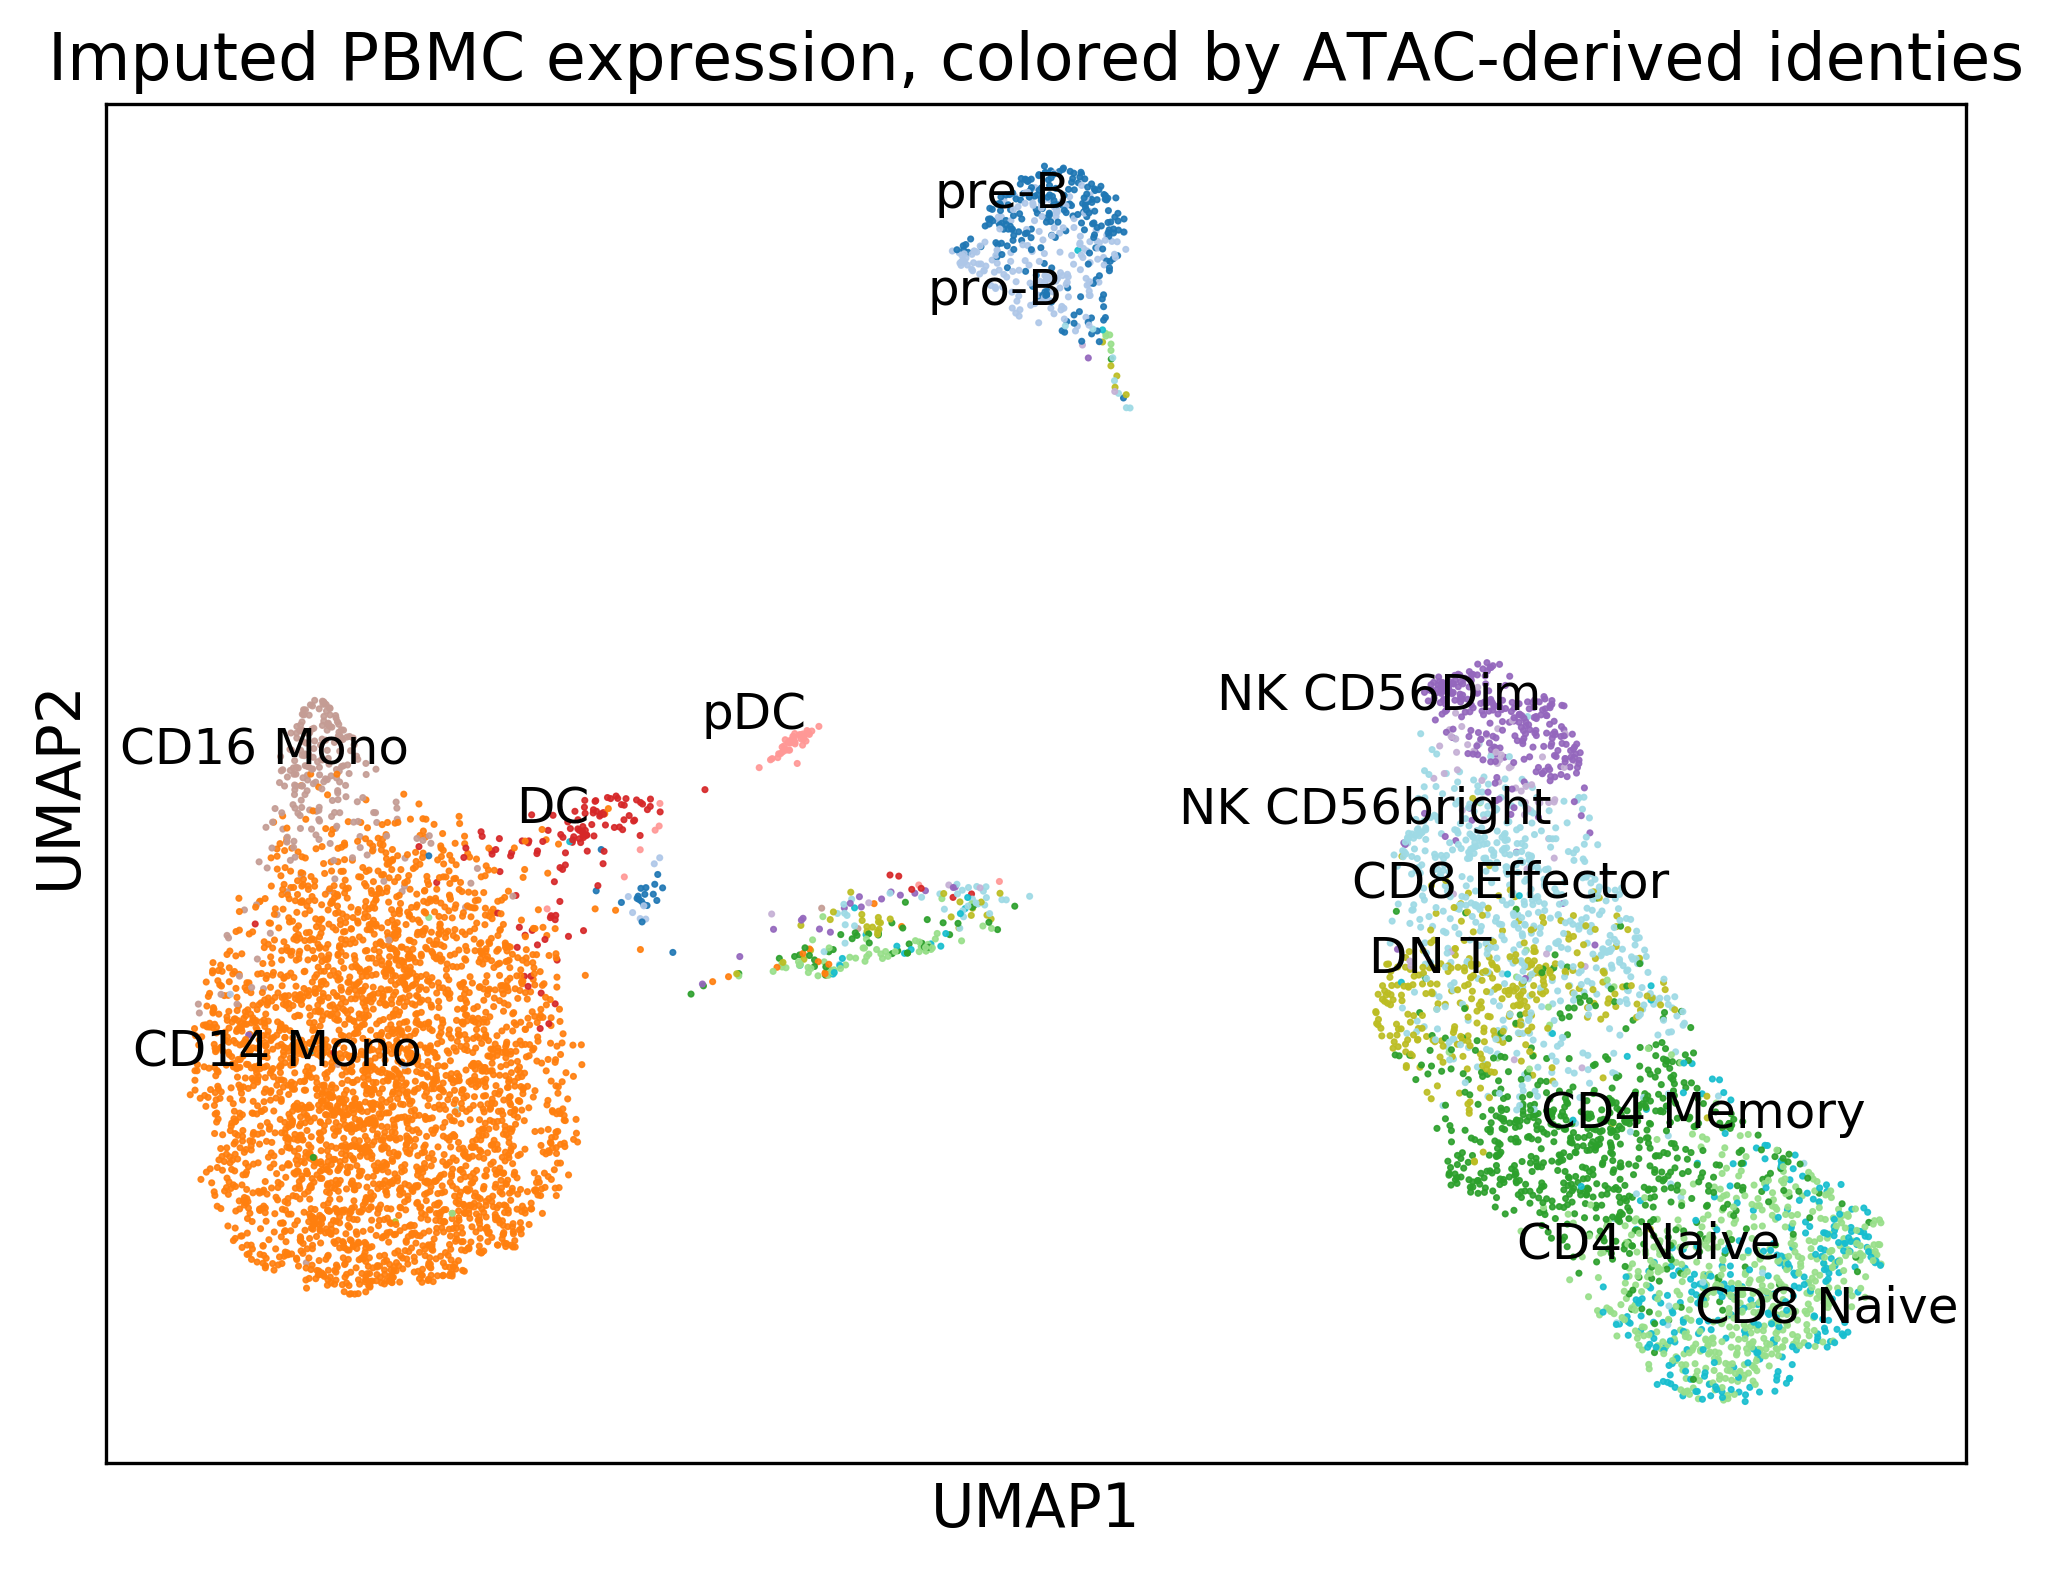

In [8]:
importlib.reload(plot_utils)

def celltype_to_color_atac_base(celltype:str):
    """Assign each celltype a consistent, unique color"""
    tab20 = plt.get_cmap("tab20")
    mapping = {
        "CD14 Mono": tab20(2),
        "CD16 Mono": tab20(11),
        "CD4 Memory": tab20(4),
        "CD4 Naive": tab20(5),
        "CD8 Effector": tab20(19),
        "CD8 Naive": tab20(18),
        "DC": tab20(6),
        "DN T": tab20(16),
        "NK CD56Dim": tab20(8),
        "NK CD56bright": tab20(9),
        "pDC": tab20(7),
        "pre-B": tab20(0),
        "pro-B": tab20(1),
    }
    rgb = dict(enumerate(mapping.values()))[celltype][:3]  # Drops alpha transparency
    if np.any(np.array(rgb) > 1):  # mpl does RGB in float
        rgb = np.array(rgb) / 255
    return tuple(rgb)

plot_utils.plot_clustering_anndata_direct_label(
    pbmc_rna_log,
    color="seurat_clustername",
    cmap=celltype_to_color_atac_base,
    adjust=True,
    title="Imputed PBMC expression, colored by ATAC-derived identies",
).show()

## Highlight the expression of key marker genes

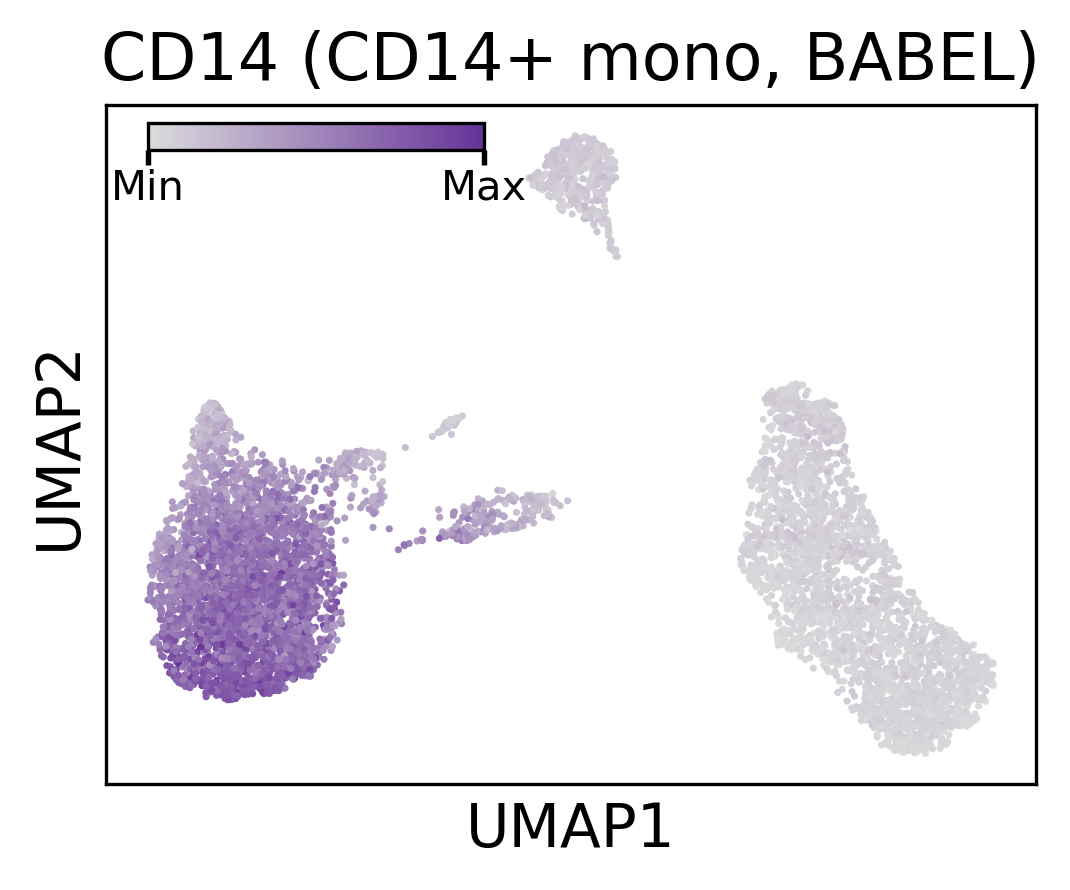

In [9]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "CD14",
    title="CD14 (CD14+ mono, BABEL)",
    cbar_pos=[0.16, 0.83, 0.28, 0.03],
).show()

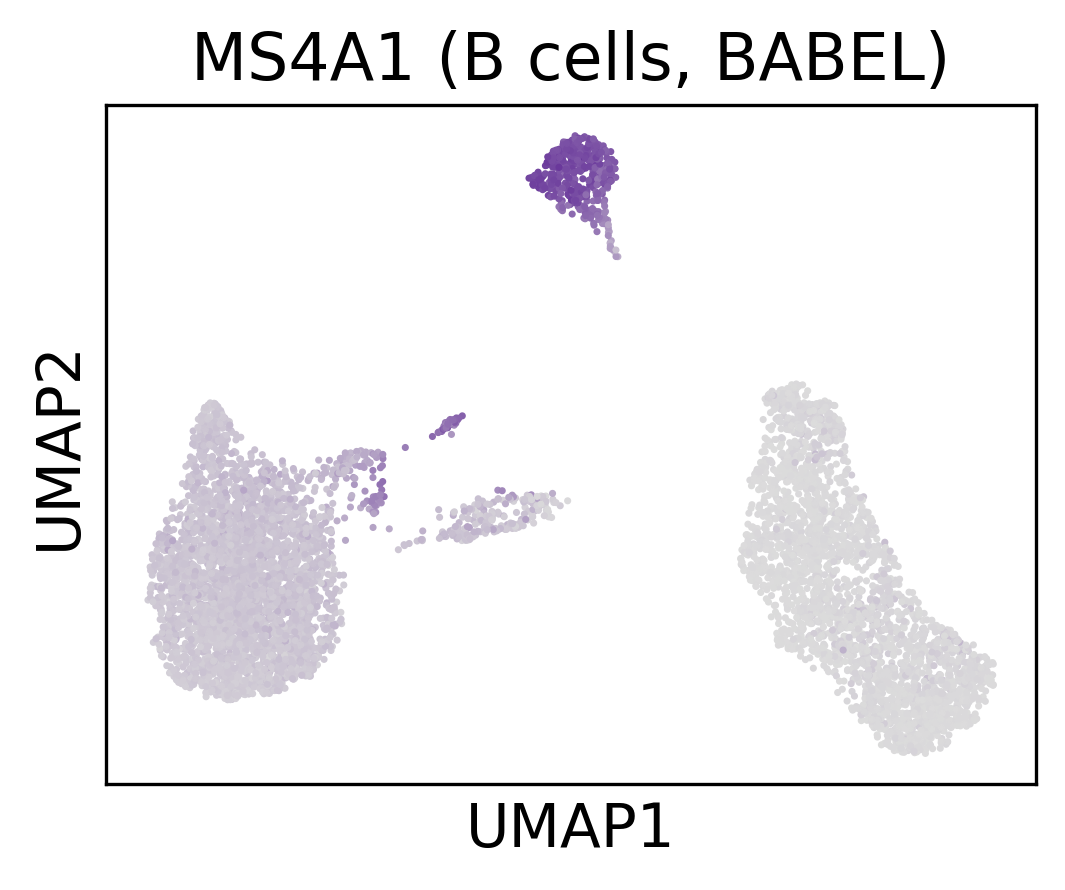

In [10]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "MS4A1",
    title="MS4A1 (B cells, BABEL)",
).show()

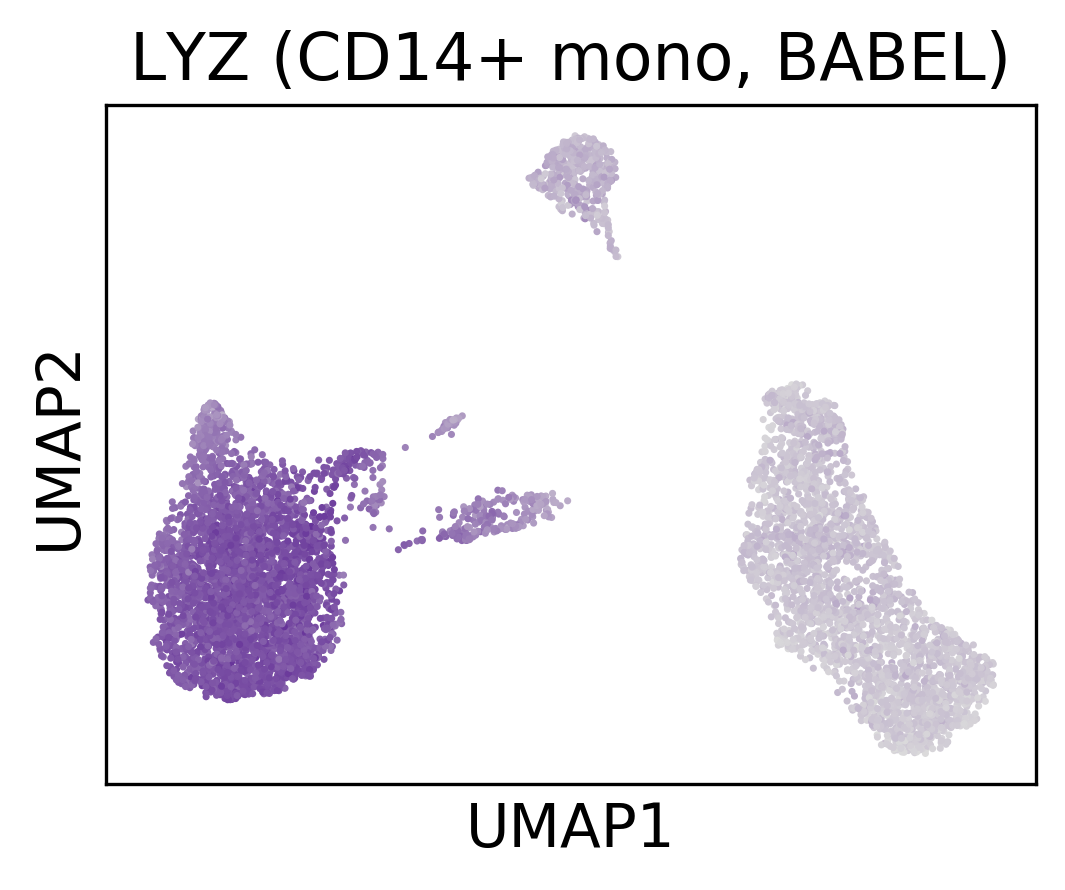

In [11]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "LYZ",
    title="LYZ (CD14+ mono, BABEL)",
).show()

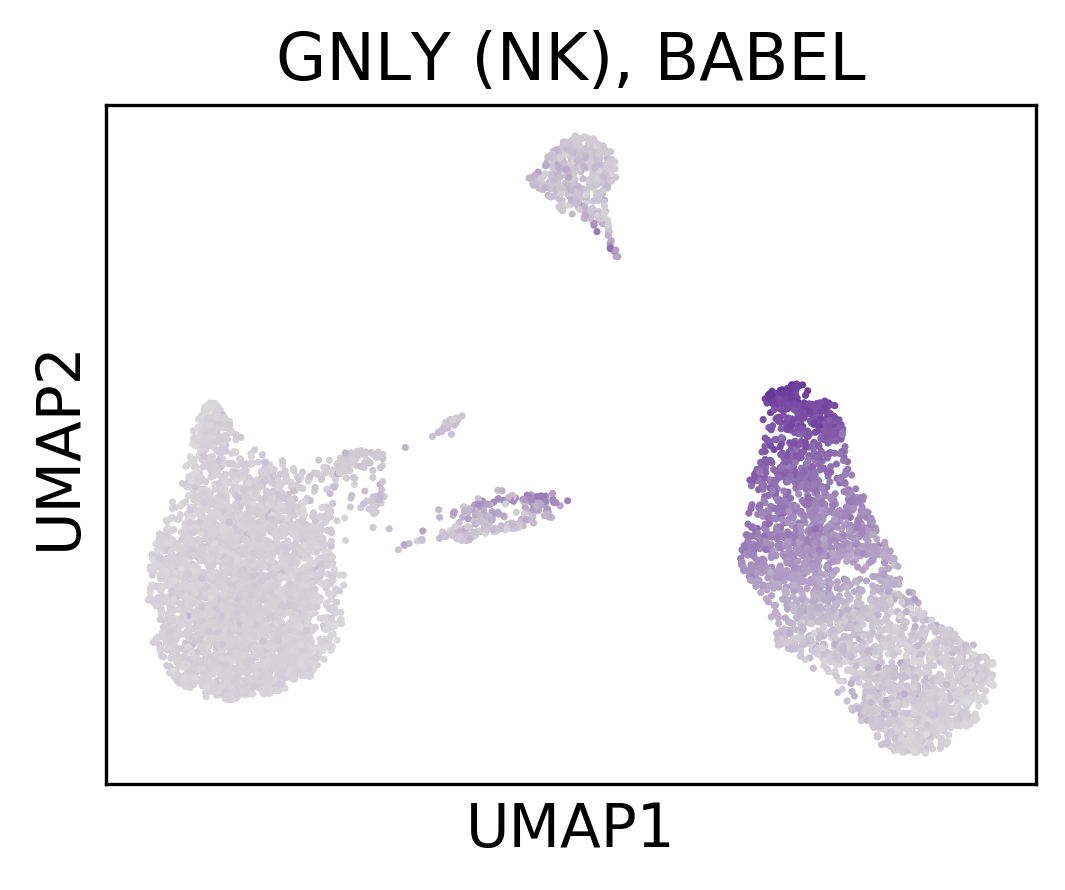

In [12]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "GNLY",
    title="GNLY (NK), BABEL",
).show()